In [1]:
#gneral libraries
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import random as rn

#plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

#Image processing libraries
import cv2
from PIL import Image
from PIL import ImageOps


import struct #binary format hanling library
import xml.etree.ElementTree as ET #xml handling library

import warnings
warnings.filterwarnings("ignore")

In [2]:
import tensorflow as tf
from imgaug import augmenters as iaa

In [3]:
##imports
from tensorflow.keras.layers import Conv2D, Dense, Activation, Dropout, BatchNormalization, ReLU, Concatenate, Conv2DTranspose
from tensorflow.keras import Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.models import Model

## Architecture of the Network

In [4]:
def DenseNet121(input_shape):
    
    dense = tf.keras.applications.densenet.DenseNet121(include_top=False, weights='imagenet', input_shape=input_shape)
    dense.trainable = False
    layer_names = ['conv3_block12_concat', 'conv4_block24_concat',  'relu']
    outputs = [dense.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([dense.input], outputs)
    
    return model 

In [5]:
class TableDecoder(tf.keras.layers.Layer):  #kernels = [(1,1), (2,2)], #strides = [(1,1), (2,2)]

    def __init__(self, kernels, strides):
        super().__init__()
        self.conv_7 = Conv2D(kernel_size=kernels[0], filters=64, strides=strides[0], kernel_regularizer=tf.keras.regularizers.l2(0.002)) #First convolutional layer in Table_Decoder

        self.upsample_1_table = Conv2DTranspose(filters=64, kernel_size = kernels[1], strides = strides[1], padding='same')
        self.upsample_2_table = Conv2DTranspose(filters = 64, kernel_size = kernels[1], strides = strides[1], padding='same')
        self.upsample_3_table = Conv2DTranspose(filters = 64, kernel_size = kernels[1], strides = strides[1], padding='same')
        self.upsample_4_table = Conv2DTranspose(filters = 64, kernel_size = kernels[1], strides = strides[1], padding='same')
        self.upsample_5_table = Conv2DTranspose(filters=1, kernel_size=kernels[1], strides=strides[1], padding='same', activation='sigmoid')

    def call(self, input_, pool3, pool4):
        
        x = self.conv_7(input_)  #input.shape = (None, 32, 32, 256) and output.shape = (None, 32, 32, 256)
        
        x = self.upsample_1_table(x)  #after upsampling output.shape = (None, 64, 64, 256)
        x = Concatenate()([x, pool4]) 
       
        x = self.upsample_2_table(x) #after upsampling output.shape = (None, 128, 128, 256)
        x = Concatenate()([x, pool3]) 
        
        x = self.upsample_3_table(x)
        x = self.upsample_4_table(x)
        x = self.upsample_5_table(x) #after upsampling output.shape = (None, 1024, 1024, 1)
        
        return x

In [6]:
class ColumnDecoder(tf.keras.layers.Layer):    #kernels = [(1,1), (2,2)], #strides = [(1,1), (2,2)]
    
    def __init__(self, kernels, strides):
        super().__init__()
        self.conv_7 = Conv2D(kernel_size=kernels[0], filters=64, strides=strides[0], activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.004), kernel_initializer='he_normal') #first conv in column_decoder
        self.drop = Dropout(0.8)
        self.conv_8 = Conv2D(kernel_size=kernels[0], filters=64, strides=strides[0], kernel_regularizer=tf.keras.regularizers.l2(0.004), kernel_initializer='he_normal',) #second conv in column_decoder
        
        self.upsample_1_column = Conv2DTranspose(filters = 64, kernel_size = kernels[1], strides = strides[1], padding='same')
        self.upsample_2_column = Conv2DTranspose(filters = 64, kernel_size = kernels[1], strides = strides[1], padding='same')
        self.upsample_3_column = Conv2DTranspose(filters = 64, kernel_size = kernels[1], strides = strides[1], padding='same')
        self.upsample_4_column = Conv2DTranspose(filters = 64, kernel_size = kernels[1], strides = strides[1], padding='same')
        self.upsample_5_column = Conv2DTranspose(filters = 1, kernel_size = kernels[1], strides = strides[1], padding='same', activation='sigmoid')

    def call(self, input_, pool3, pool4):
        
        x = self.conv_7(input_) #input.shape = (None, 32, 32, 256) and output.shape = (None, 32, 32, 256)
        x = self.drop(x)  
        x = self.conv_8(x) #after second convultion output.shape = (None, 32, 32, 256)

        x = self.upsample_1_column(x) #after upsampling output.shape = (None, 64, 64, 256)
        x = Concatenate()([x, pool4]) 
       
        x = self.upsample_2_column(x) #after upsampling output.shape = (None, 128, 128, 256)
        x = Concatenate()([x, pool3]) 
        
        x = self.upsample_3_column(x)
        x = self.upsample_4_column(x)
        x = self.upsample_5_column(x) #after upsampling output.shape = (None, 1024, 1024, 1)

        return x

In [7]:
class TableNet(tf.keras.Model):
    def __init__(self, encoder, branch_kernels, branch_strides, input_shape):
        super(TableNet, self).__init__()
        if encoder == 'VGG19':
            self.feature_extractor = VGG19(input_shape)
        elif encoder == 'DenseNet121':
            self.feature_extractor = DenseNet121(input_shape)
        elif encoder == 'RestNet50':
            self.feature_extractor = RestNet50(input_shape)
        elif encoder == 'MobileNet_v2':
            self.feature_extractor = MobileNet_v2(input_shape)
            
        self.conv_1= Conv2D(filters=64, kernel_size=(1,1), activation='relu', name='common_conv_1', kernel_regularizer=l2(0.04))
        self.drop_1= Dropout(0.8)
        self.conv_2= Conv2D(filters=64, kernel_size=(1,1), activation='relu', name='common_conv_2', kernel_regularizer=l2(0.04))
        self.drop_2= Dropout(0.8)
        
        self.table_branch = TableDecoder(branch_kernels, branch_strides)
        self.column_branch = ColumnDecoder(branch_kernels, branch_strides)
        
    def call(self, x):
        pool3, pool4, pool5 = self.feature_extractor(x)
        
        out = self.conv_1(pool5)
        out = self.drop_1(out)
        out = self.conv_2(out)
        out = self.drop_2(out)
        
        table_output = self.table_branch(out, pool3, pool4)
        column_output = self.column_branch(out, pool3, pool4)
        
        return table_output, column_output

## Utilites

In [8]:
def visualize_training(history):
    '''utitlity function to plot the training history of the network'''
    
    epochs = [i for i in range(1, len(history.history['loss'])+1)]
    terms = ['lr', 'output_1_loss', 'output_2_loss', 'output_1_f1_score', 'output_2_f1_score', 'loss']
    val_terms = ['lr', 'val_output_1_loss', 'val_output_2_loss', 'val_output_1_f1_score', 'val_output_2_f1_score', 'val_loss']
    titles = ['learning_rate', 'table_loss', 'column_loss', 'table_f1_score', 'column_f1_score', 'aggregated_loss']

    plt.figure(figsize=(20,20))
    for i in range(6):
        plt.subplot(3,3,i+1)
        plt.plot(epochs, history.history[terms[i]],label=terms[i])
        plt.plot(epochs, history.history[val_terms[i]],label=val_terms[i])
        plt.xticks(epochs)
        plt.legend(loc='lower left')
        plt.grid()
        plt.title('epochs vs '+titles[i])
    plt.show()

References
1. https://www.educba.com/opencv-approxpolydp/ 
2. https://medium.com/analytics-vidhya/opencv-findcontours-detailed-guide-692ee19eeb18

In [9]:
def get_pred_masks(model, input_image_path, preprocessing=False):
    '''predicting the table and column masks for given image using the given model'''
    
    if preprocessing:
        image_original = Image.open(input_image_path)
        image = image_original.convert('L').convert('RGB')                   #converting the input image into greyscale and again into RGB to remove the different colors of the image.
        image = ImageOps.equalize(image, mask=None)                         #histogram equilization
        input_image_processed = np.array(image.resize(new_image_shape))   #resizing Image to new shape
    else:
        input_image_processed = cv2.imread(input_image_path, cv2.IMREAD_UNCHANGED)
        
    input_image = np.expand_dims(input_image_processed/255.0, axis=0) #expanding the dimensions to add batch_size such that it is compatible
    
    table_mask_pred, column_mask_pred = model(input_image) #predicting the masks using trained model 
    
    
    table_mask = np.squeeze(tf.cast((table_mask_pred>0.5), dtype=tf.int32).numpy(), axis=0).astype(np.uint8)
    column_mask = np.squeeze(tf.cast((column_mask_pred>0.5), dtype=tf.int32).numpy(), axis=0).astype(np.uint8)
    
    return input_image_processed, table_mask, column_mask

## Loading DenseNet121 feature_extractor

In [10]:
os.environ['PYTHONHASHSEED'] = '2'

tf.keras.backend.clear_session()

## Set the random seed values to regenerate the model.
np.random.seed(2)
rn.seed(2)

tf.keras.backend.clear_session()

input_shape = (1024, 1024, 3)

kernels = [(1,1), (2,2)]
strides = [(1,1), (2,2)]

model_dense = TableNet(encoder='DenseNet121', branch_kernels=kernels, branch_strides = strides, input_shape = input_shape)

In [11]:
# dense_loaded = tf.keras.models.load_model(r'C:\Users\ADMIN\Documents\Case study 2\saved_models\all\model_dense', 
#                                           custom_objects={'TableNet':TableNet, 'F1_Score':F1_Score})

model_dense.load_weights(r'C:\Users\ADMIN\Documents\Case study 2\saved_models\model_dense_diceloss\cp-0020.ckpt')

In [14]:
# sample_images = ['10.1.1.193.1812_24', '10.1.1.192.1805_60', '10.1.1.178.3008_5', '10.1.1.185.1557_7', '10.1.1.160.686_7',
# '10.1.1.160.624_15', '10.1.1.160.538_23', '10.1.1.160.509_17', '10.1.1.120.1603_23', '10.1.1.100.2013_24', 
# '10.1.1.100.2026_8', '10.1.1.34.3224_4', '10.1.1.20.2130_26', '10.1.1.7.2189_4', '10.1.1.6.2336_18', 
# '10.1.1.1.2134_223', '10.1.1.1.2129_6', '10.1.1.1.2087_26', '10.1.1.1.2044_7', '10.1.1.1.2036_17']

# Extracting data using tesseract OCR

In [15]:
import pytesseract
from io import StringIO

pytesseract.pytesseract.tesseract_cmd = r'C:/Program Files/Tesseract-OCR/tesseract.exe'

In [16]:
def fixMasks(table_mask):
    '''Approximating the table surface such that it is a 4 sided polygon either rectangle or square'''
    
    
    #contours is a list where it contains boundary the co-ordinates (x,y) which are approximated to save the memory
    contours, table_heirarchy = cv2.findContours(table_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    table_contours = []

    for c in contours:
        
        if cv2.contourArea(c)>9000:
            table_contours.append(c)
    
    if len(table_contours) == 0:
        return None
    
    table_boundRect = [None]*len(table_contours)

    for i, c in enumerate(table_contours):     #approximating the table boundaries
        polygon = cv2.approxPolyDP(c, 1, True)
        table_boundRect[i] = cv2.boundingRect(polygon)
    
    #table bounding Box
    table_boundRect.sort()
    
    return  table_boundRect

In [42]:
def Extraction(image, table_boundRect):
    '''For a given input processed image and its table boundaries, it returns the text'''
    
    if table_boundRect:
        for i,(x,y,w,h) in enumerate(table_boundRect): #for each table in the givne image
            image_crop = image[y:y+h,x:x+w] #cropping the image with respect to the table boundaries
            plt.figure(figsize=(10,8))
            plt.imshow(image_crop)
            plt.title('Cropped Image')
            plt.show()
            data = pytesseract.image_to_string(image_crop) #extracting the text using ocr
            if data:
                try:
                    df = pd.read_csv(StringIO(data),sep=r'\|',engine='python')
                    df.to_csv(f'Table_{i+1}.csv')
                    print(df)
                except pd.errors.ParserError:
                    try:
                        df = pd.read_csv(StringIO(data),delim_whitespace=True,engine='python')
                        df.to_csv(f'Table_{i+1}.csv')
                        print(df)
                    except pd.errors.ParserError:
                        text_file = open(f'Text_{i+1}.txt', "w")
                        text_file.write(data)
                        print(data)
            else:
                print('No data is identified by tesseract OCR')
    else:
        plt.figure(figsize=(10,8))
        plt.imshow(image)
        plt.title('No table found to extract structural data')
        plt.show()

In [65]:
def display(image):
    image = cv2.imread(image, cv2.IMREAD_UNCHANGED)
    plt.figure(figsize=(10, 8))
    plt.imshow(image)
    plt.title('Input to the Table Network')
    plt.show()

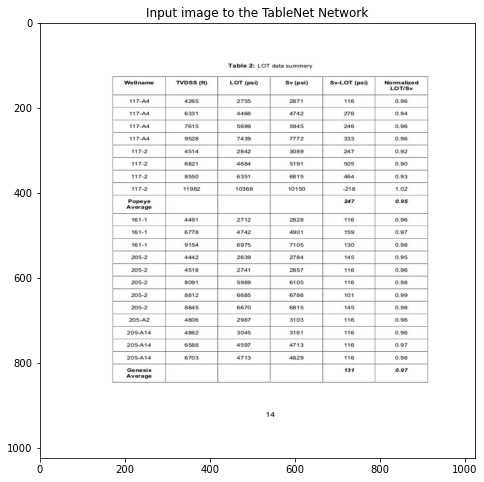

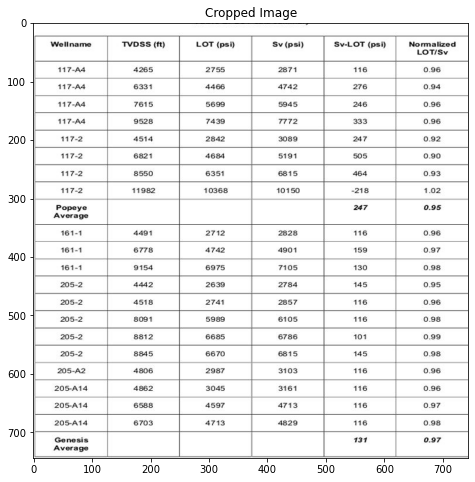

   Wellname Tvpss (ft) LOT (psi) Sv (psi) ‘Sv-LOT (psi)
0                                              LOT/Sv  
1                       I7-A4 4265 2755 2871 116 0.96  
2                      VI7-A4 6331 4466 4742 276 0.94  
3                      TIT-A4 7615 5699 s945 246 0.96  
4                      MIT-A4 9528 7439 7772 333 0.96  
5                        17-2 4514 2842 3089 247 0.92  
6                        17-2 6821 4684 S191 50S 0.90  
7                        17-2 8550 6351 6815 464 0.93  
8                    17-2 11982 10368 10150 -218 1.02  
9                                     Popeye 247 0.95  
10                                            Average  
11                      161-1 4491 2712 2828 116 0.96  
12                      161-1 6778 4742 4901 159 0.97  
13                      161-1 9154 6975 7105 130 0.98  
14                      205-2 4442 2639 2784 145 0.95  
15                      205-2 4518 2741 2857 116 0.96  
16                      205-2 8091 5989 6105 116

In [45]:
test_1 = r'C:\Users\ADMIN\Documents\Case study 2\marmot_preprocessed\image\10.1.1.193.1812_24.jpeg'

input_image, pred_table_mask, pred_column_mask = get_pred_masks(model_dense, test_1)
table_bound = fixMasks(pred_table_mask)
display(test_1)
Extraction(input_image, table_bound)

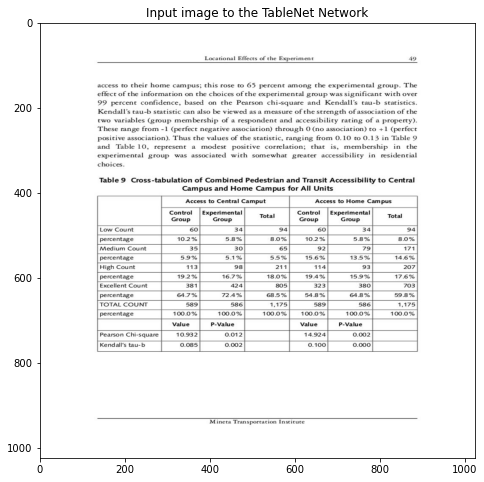

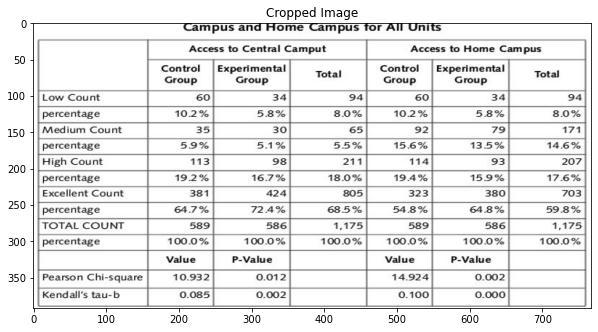

Campus and Frome Campus for All Units

Access to Central Camput

Access to Home Campus

Control | Experimental

Control

Experimental

Group Group ome Group Group moral
Low Count 60 34 94 60 34 94
percentage 702% 58% 8.0%| 102% 5B% 80%
‘Medium Count 35 30 6 92 79 71
percentage 59% BA% 55%| 156% 135% 14.6%
High Count 713 98 244 714 93 207)
percentage 792% 167% 78.0%| 194% 159% 176%
Excellent Count 381 24 805 323 380 703
percentage ar% 72a% 5%| 548% 8% 598%
TOTAL COUNT 589 586 7475 589) 586 71475
percentage 700.0%] _100.0%| _1000%| 100.0%| _1000%| 100.0%

value P-Value value P-value
Pearson Chi-square| 10.932 0.012 714.924 0.002
Kendall's tau-b 0.085 0.002 0.100 0.000




In [46]:
test_2 = r'C:\Users\ADMIN\Documents\Case study 2\marmot_preprocessed\image\10.1.1.192.1805_60.jpeg'
input_image, pred_table_mask, pred_column_mask = get_pred_masks(model_dense, test_2)
table_bound = fixMasks(pred_table_mask)
display(test_2)
Extraction(input_image, table_bound)

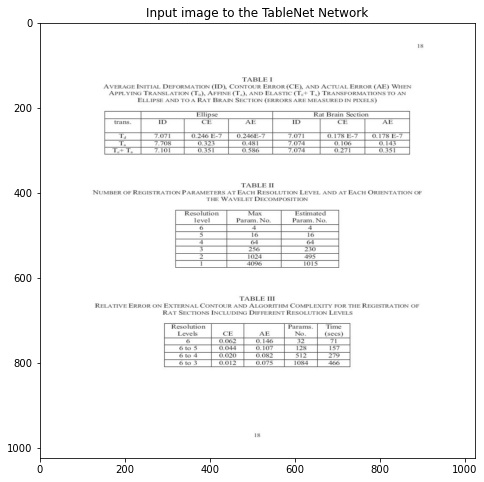

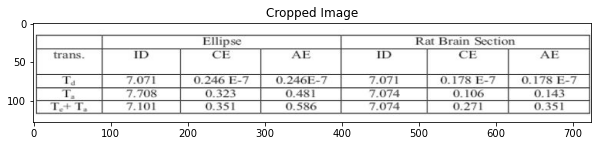

Ellipse

Rat Brain Section

trans. 1D CE AE 1D CE AE
Ta 7.071 0.246 E-7_ | 0.246E-7 7.071 O18 E-7 | 0.178 E-7
Te 7-708 0323 0-487 7.074 0.106 0.143

T+ T. 7101 0.351 0.586 7.074 0.271 0351




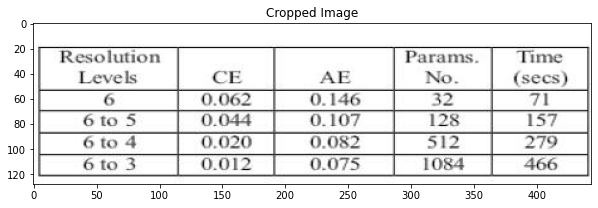

         Resolution Params.    Time
0    Levels CE AE No. (secs)    NaN
1       a 0.062 0.146 32, 71    NaN
2  bio 5 0.044 0.107 128 157    NaN
3   6to4 0.020 0.082 312 279    NaN
4  6103 0.012 0.075, TOS 466    NaN


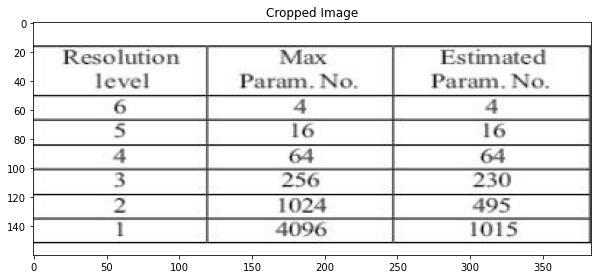

      Resolution Max Estimated
0  level Param. No. Param. No.
1                        6 4 4
2                      3 16 16
3                        4 o o
4                    3 256 230
5                  2 1024 495,
6                  T 4096 Tors


In [47]:
test_3 = r'C:\Users\ADMIN\Documents\Case study 2\marmot_preprocessed\image\10.1.1.6.2336_18.jpeg'
input_image, pred_table_mask, pred_column_mask = get_pred_masks(model_dense, test_3)
table_bound = fixMasks(pred_table_mask)
display(test_3)
Extraction(input_image, table_bound)

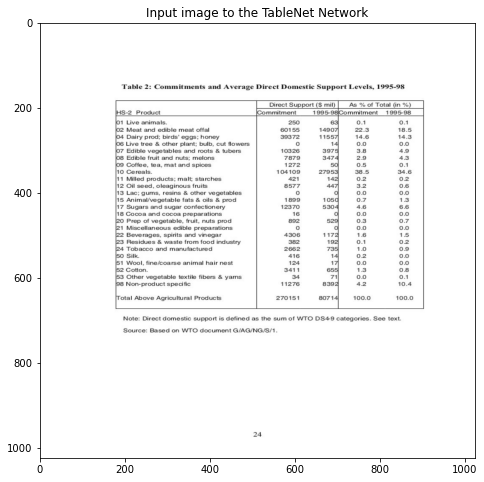

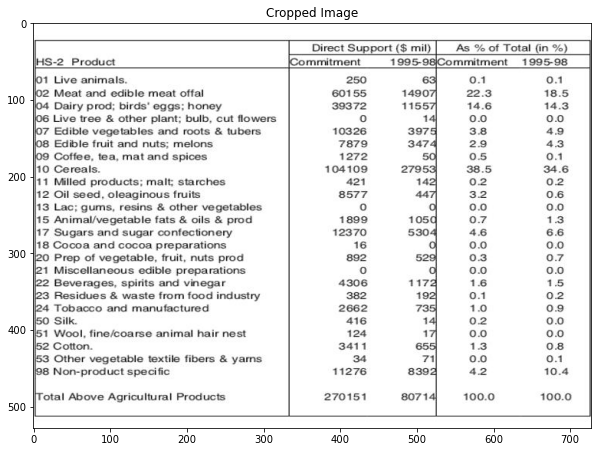

                              Direct Support ($ mil)   _As % of Total (in %)
0                 IHS-2 Product [Commitment __1995-98     Gommitment 1995-98
1                           1 Live animals. 250 o4 on                   None
2   2 Meat and edible meat offal 60155 14907, 22.3...                   None
3   Dairy prod; birds’ eggs; honey 39372 11557] 14...                   None
4   Live tree & other plant; bulb, cut flowers ° 1...                   None
5   7 Edible vegetables and roots & tubers 10326 3...                   None
6       Edible fruit and nuts; melons 7879 347: 29 43                   None
7              Coffee, tea, mat and spices 1272 os on                   None
8                   lO Cereals. 104109 279! 38.5 34.6                   None
9   }11 Milled products; malt; starches 421 142 02 02                   None
10    }12 Oil seed, oleaginous fruits 8577 447] 32 06                   None
11  l13 Lac; gums, resins & other vegetables ° 0.0...                   None

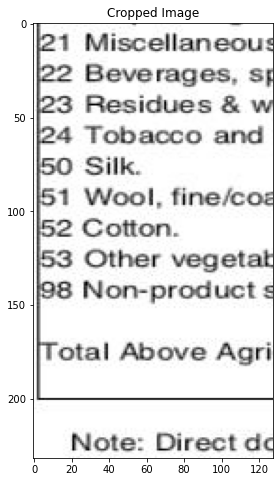

    1 Miscellaneous
0     Beverages, 5}
1      Residues & w
2    24 Tobacco and
3             Silk.
4  1 Wool, fine/cos
5           Cotton.
6     Other vegetat
7     Non-product s
8  ‘otal Above Agri
9   Note: Direct de


In [48]:
test_4 = r'C:\Users\ADMIN\Documents\Case study 2\marmot_preprocessed\image\10.1.1.20.2130_25.jpeg'
input_image, pred_table_mask, pred_column_mask = get_pred_masks(model_dense, test_4)
table_bound = fixMasks(pred_table_mask)
display(test_4)
Extraction(input_image, table_bound)

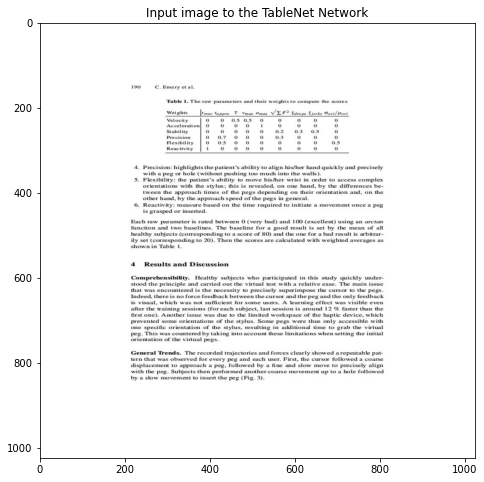

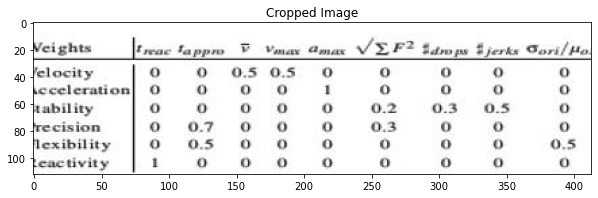

         eights fereae appro    TF Vmax tmae  AEF? Sarope tjerks Fort!  Ho
0        locity      0     0  0505    0    0     0      0      °  None NaN
1  cceleration]      0  «6-0    =O   Ot    °  None   None   None  None NaN
2             ©      0     0     0    ©   02    03     os      0  None NaN
3             0     07     0     0    0   03     0     oO      °  None NaN
4             0     05    00     0    ©    0     ©   None   None  None NaN
5      cactiviy      |     1     ©    ©    ©     0      0      ©    Oo NaN


In [54]:
test_5 = r'C:\Users\ADMIN\Documents\Case study 2\marmot_preprocessed\image\10.1.1.178.3008_5.jpeg'
input_image, pred_table_mask, pred_column_mask = get_pred_masks(model_dense, test_5)
table_bound = fixMasks(pred_table_mask)
display(test_5)
Extraction(input_image, table_bound)

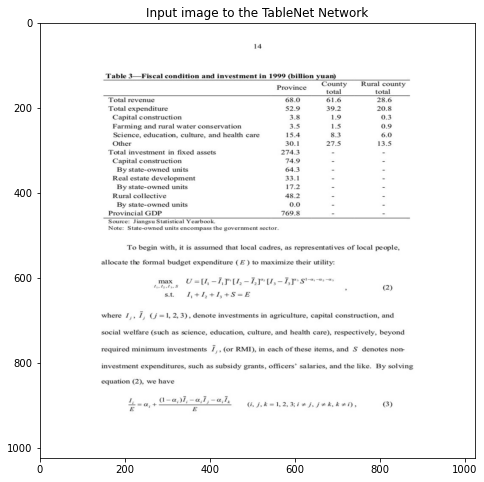

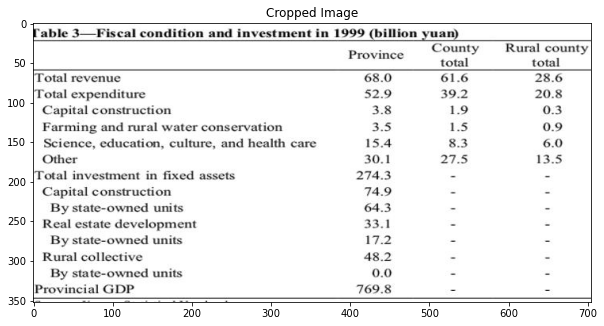

   lable 3—Fiscal condition and investment in 1999 (billion yuan)
0                      Province County — Rural county            
1                                         total total            
2                        Total revenue 68.0 61.6 28.6            
3                    Total expenditure 52.9 39.2 20.8            
4                     Capital construction 3.8 1.9 03            
5     Farming and rural water conservation 3.5 1.5 09            
6   Science, education, culture, and health care 1...            
7                                Other 30.1 27.5 13.5            
8          Total investment in fixed assets 274.3 - -            
9                       Capital construction 74.9 - -            
10                      By state-owned units 64.3 - -            
11                   Real estate development 33.1 - -            
12                      By state-owned units 17.2 - -            
13                          Rural collective 48.2 - -            
14        

In [55]:
test_6 = r'C:\Users\ADMIN\Documents\Case study 2\marmot_preprocessed\image\10.1.1.1.2084_18.jpeg'
input_image, pred_table_mask, pred_column_mask = get_pred_masks(model_dense, test_6)
table_bound = fixMasks(pred_table_mask)
display(test_6)
Extraction(input_image, table_bound)

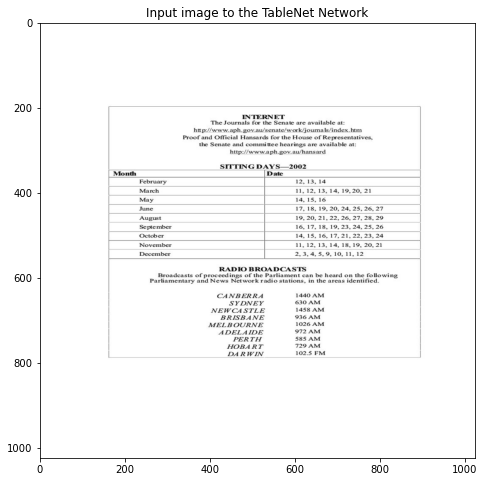

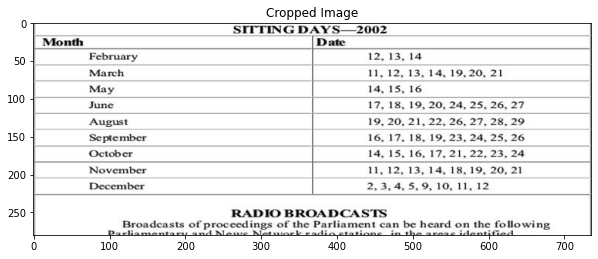

                                    SITTING DAYS—2002
0                                                Date
1                                           12, 13,14
2                           11, 12, 13, 14, 19,20, 21
3                                          14, 15, 16
4                      17, 18, 19, 20, 24, 25, 26, 27
5                      19, 20, 21, 22, 26, 27, 28, 29
6                      16, 17, 18, 19, 23, 24, 25, 26
7                      14, 15, 16, 17, 21, 22, 23, 24
8                      11, 12, 13, 14, 18, 19, 20, 21
9                             2, 3,4, 5,9, 10, 11, 12
10                                   RADIO BROADCASTS
11  Broadcasts of proceedings of the Parliament ca...


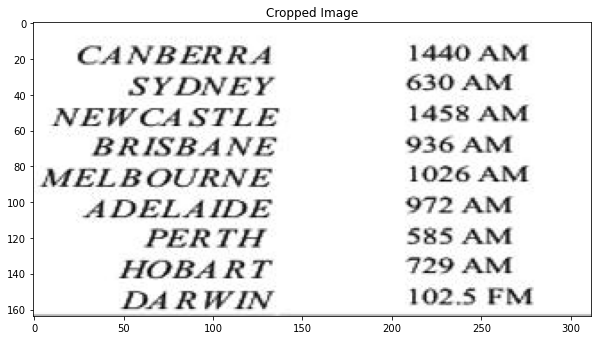

     CANBERRA
0      SYDNEY
1   NEWCASTLE
2    BRISBANE
3   MELBOURNE
4    ADELAIDE
5       PERTH
6      HOBART
7      DARWIN
8     1440 AM
9      630 AM
10    1458 AM
11    936. AM
12    1026 AM
13     972 AM
14     585 AM
15     729 AM
16   102.5 FM


In [56]:
test_7 = r'C:\Users\ADMIN\Documents\Case study 2\marmot_preprocessed\image\10.1.1.190.1812_2.jpeg'
input_image, pred_table_mask, pred_column_mask = get_pred_masks(model_dense, test_7)
table_bound = fixMasks(pred_table_mask)
display(test_7)
Extraction(input_image, table_bound)

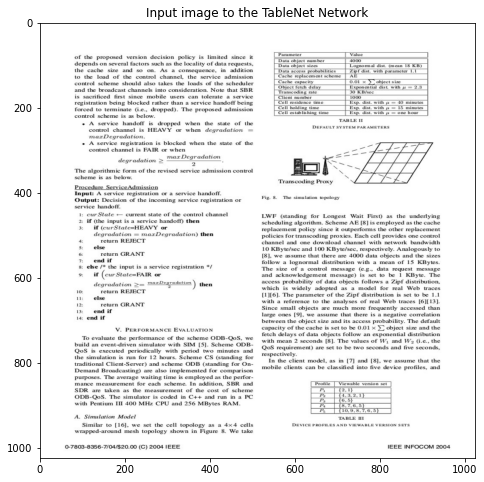

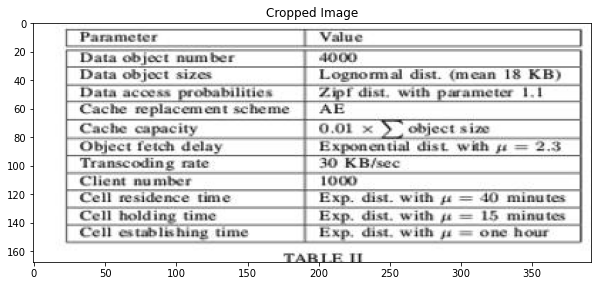

                        ‘Parameter
0                            Value
1              ‘Data object number
2                             4000
3               ‘Data object sizes
4       Logaomal dist_ mean 18 KBY
5         ‘Data access probabilita
6      ipl dist with parameter 1.1
7         Cache replacement scheme
8                               AE
9                   Cache capacity
10             0.01 $7 object size
11             ‘Object fetch delay
12       Exponeadal dist wah f= 25
13               ‘Transcoding tate
14                        30 KBhee
15                   Client number
16             Cell wesidence time
17     Exp. dia with @ = 0 minutes
18              ‘Cell holding time
19  Exp. dist_with j« = 15 minates
20           Cell erublishing time
21  “Exp. dist. with jz = one hour


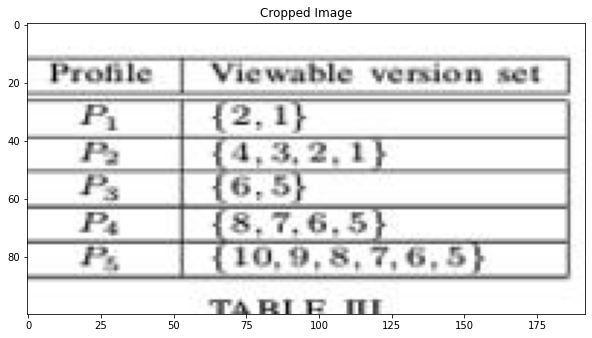

       Pi [2 tF
0   P4435, 2.0F
1     Pa t6: 55
2    cae CACHES
3  Pe. 9,5, FSP


In [57]:
test_8 = r'C:\Users\ADMIN\Documents\Case study 2\marmot_preprocessed\image\10.1.1.1.2018_8.jpeg'
input_image, pred_table_mask, pred_column_mask = get_pred_masks(model_dense, test_8)
table_bound = fixMasks(pred_table_mask)
display(test_8)
Extraction(input_image, table_bound)

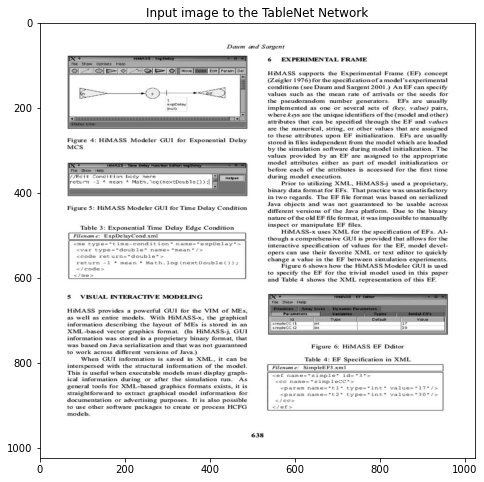

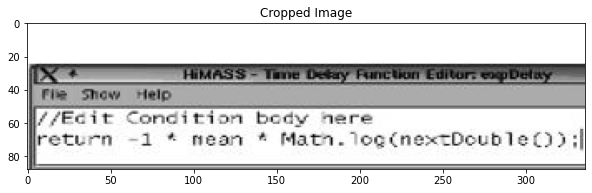

                 [/ecit Concition body nere
0  return 2 * mean * Mata. log(nexcDoublec)


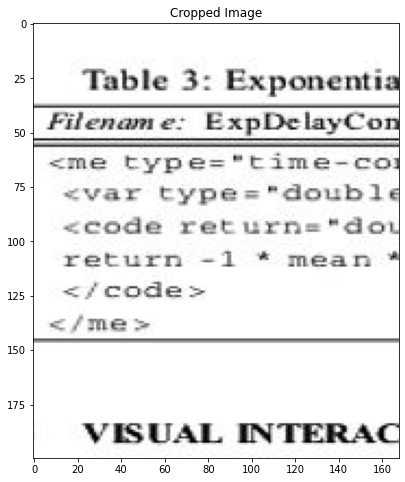

      Table 3: Exponentis
0  “Filenam = ExpDelayCor
1      =me type="time-co:
2       <var type="double
3       <code return="dot
4      return -1 * mean *
5                 </code>
6          VISUAL INTERAC


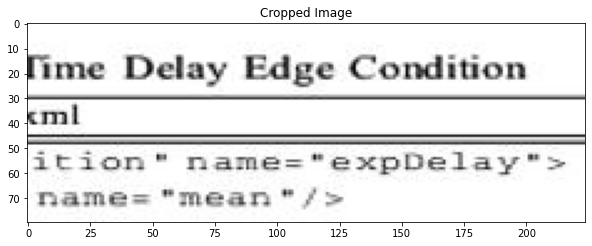

  ime Delay Edge Condition
0    tion name-"expbelay">


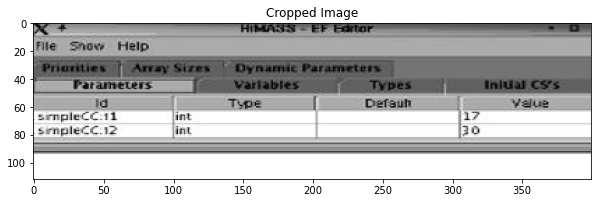

No data is identified by tesseract OCR


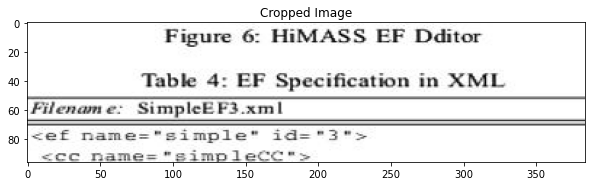

         Figure 6: HiMASS EF Dditor
0  Table 4: EF Specification in XML
1          Filenam &: SimpleEF3 xml
2               Tef name-"simple" i
3                                PO
4                                cr


In [58]:
test_9 = r'C:\Users\ADMIN\Documents\Case study 2\marmot_preprocessed\image\10.1.1.1.2010_5.jpeg'
input_image, pred_table_mask, pred_column_mask = get_pred_masks(model_dense, test_9)
table_bound = fixMasks(pred_table_mask)
display(test_9)
Extraction(input_image, table_bound)

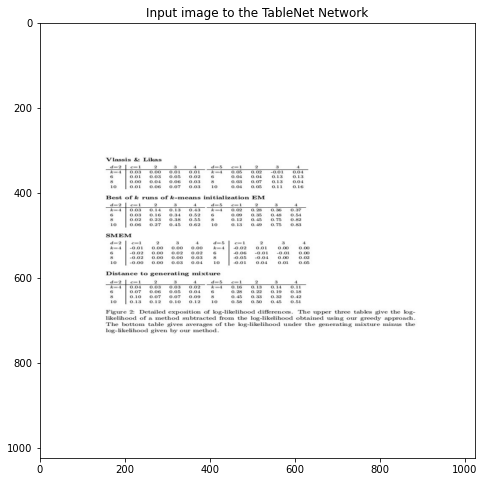

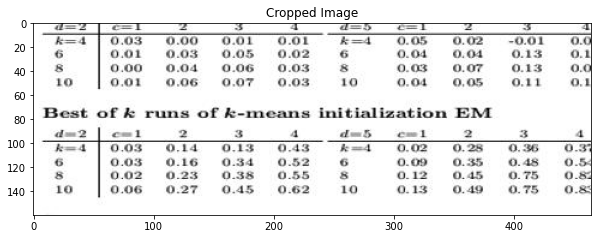

3.00 Toi —k=1 0.05 0.02 0.01 00
0:03 002 6 Oot O01 O13 0.
0.04 003 8 0.03 0.07 O13 08
0.06 003 10 0.04 005 O11 oO;

Best of k runs of k-means initialization EM

d=? [cmt 2 4 d=5 emt 2

Raa | 00S O19 013 Oa3 kat O02 0.25 O36

6 loos 016 O34 052 6 009 0.35 O.as

S |o02 O23 o3s oss & O12 O48 O78

to |o06 0:27 045 062 10 018 0.49 0.75




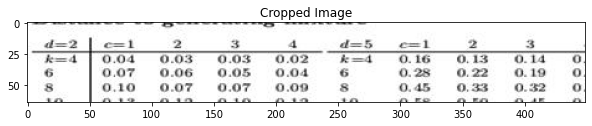

Empty DataFrame
Columns: [san]
Index: []


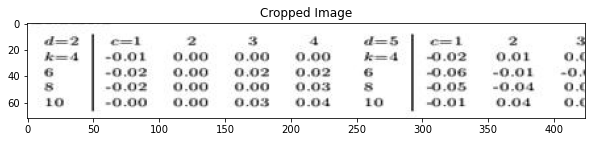

   pears
0   0.00
1   0.02
2   0:03
3  noone


In [59]:
test_10 = r'C:\Users\ADMIN\Documents\Case study 2\marmot_preprocessed\image\10.1.1.100.303_8.jpeg'
input_image, pred_table_mask, pred_column_mask = get_pred_masks(model_dense, test_10)
table_bound = fixMasks(pred_table_mask)
display(test_10)
Extraction(input_image, table_bound)

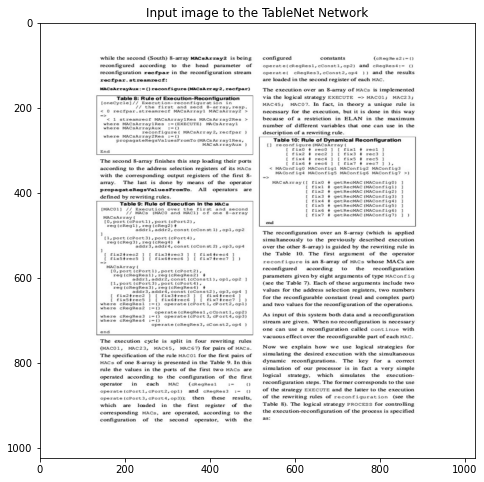

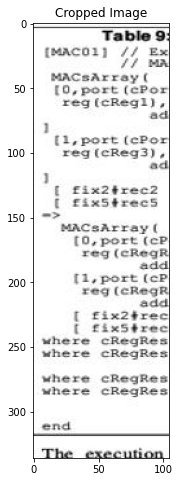

          Table 9:
0    twacor) // Ex
1               Vw
2      macaarray (
3   (0, pore (ePor
4    (2, port (eer
5       rag (eReg3
6      ( eixztrecz
7      ( Eiksteecs
8     MACEAr ray (
9     TO, pore (ee
10       og (eRegR
11      ( cixzetec
12      { FixStrec
13   wnere cheghes
14  inerze eRegnes
15   where cReates
16   UnSES cRegees
17             end
18   The exeeutien


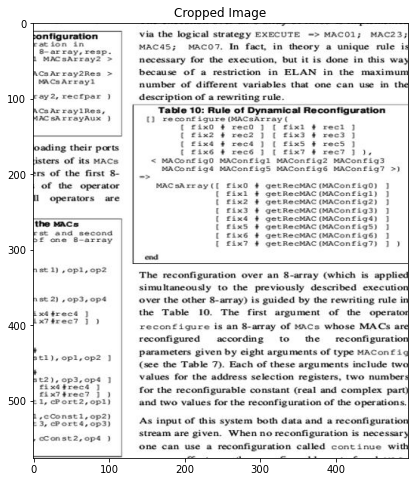

yeresp-
1 WaGearraye”>

ACeArray2Res >
SACaArray?

ray2, rectpar }

Aca ArrayiRes,
Bk oArrayAus’

oading their ports
isters of its MACS
srs of the first 8-

rt and second
bE one ecasray

net 1) , opi, op2

nst 2) ,op3,0p4

ixtfrecd 1
ixtiree? } 0

Sti), opl,op2 1

3
t2),0p3,oP¢ 1
Sixatrece)

Hittree? |)

t ,econati,op2)
5; Portas Opa}

 cConst2,op4

via the logical strategy EXECUTE => MACO1; MAC23;
MAC45; MACO7. In fact, in theory a unique rule is
necessary for the execution, but it is done in this way
because of a restriction in ELAN in the maximum
number of different variables that one can use in the
description of a rewriting rule.

‘Table 10: Rule of Dynamical Reconfiguration

() reconfigure (ACeArray (

(£400 # red) ( £4x2 # rect }
( finz # reez] [ fix3 # rec3 J
{ fixe # recd } [ Fins # recs J

( £in6 # rece} [ £427 # rec? } 0,
< MAConfigd MAConfigi MAConfig? MAContig3
MAConfigd MAConfigs MACORfigé MAConfig? >)

MACaArray({ £1x0 # getRecMAC(MAConfig0) }
[ £ie2 # getReemAc(mAConesg

In [60]:
test_11 = r'C:\Users\ADMIN\Documents\Case study 2\marmot_preprocessed\image\10.1.1.7.2174_8.jpeg'
input_image, pred_table_mask, pred_column_mask = get_pred_masks(model_dense, test_11)
table_bound = fixMasks(pred_table_mask)
display(test_11)
Extraction(input_image, table_bound)

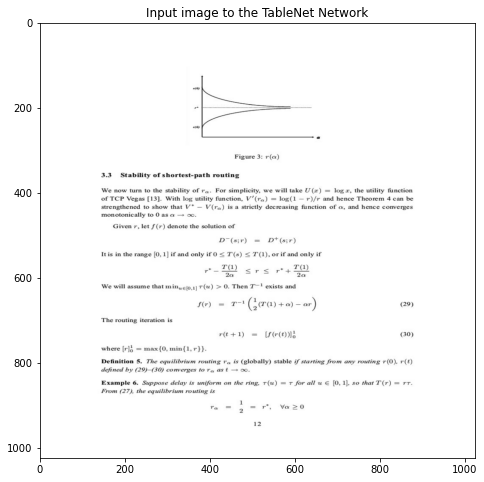

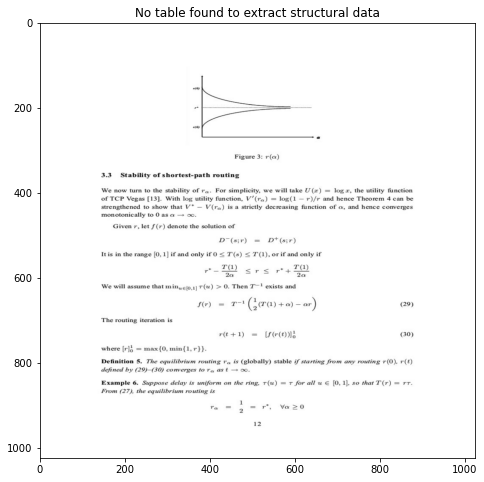

In [61]:
test_12 = r'C:\Users\ADMIN\Documents\Case study 2\marmot_preprocessed\image\10.1.1.1.2005_12.jpeg'
input_image, pred_table_mask, pred_column_mask = get_pred_masks(model_dense, test_12)
table_bound = fixMasks(pred_table_mask)
display(test_12)
Extraction(input_image, table_bound)

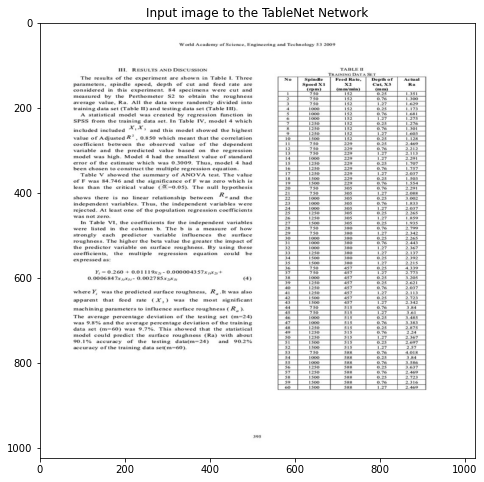

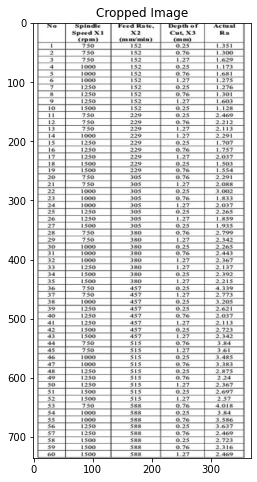

          Unnamed: 0             eee   ee dl eee
0               sa"             cues         “Re
1             women                SS       None
2         res S82 aa             None       None
3            13 37e—              100       None
4      tas tay [tess             None       None
5                {43             None       None
6             13 tse             None       None
7            13 o35—              tae       None
8             is 7e—              1st       None
9      133 137 [teas             None       None
10           ta oa¢—               ie       None
11           a a [ae             None       None
12               NaN   220 0.76 2.212       None
13             a ise             None       None
14            — i381             None       None
15            a o35—           —1 307       None
16  {1 220° 076 L787             None       None
17       Do tay [30a             None       None
18            5 oas—           —t sor       None
19          333 S315

In [62]:
test_13 = r'C:\Users\ADMIN\Documents\Case study 2\marmot_preprocessed\image\10.1.1.193.1816_3.jpeg'
input_image, pred_table_mask, pred_column_mask = get_pred_masks(model_dense, test_13)
table_bound = fixMasks(pred_table_mask)
display(test_13)
Extraction(input_image, table_bound)

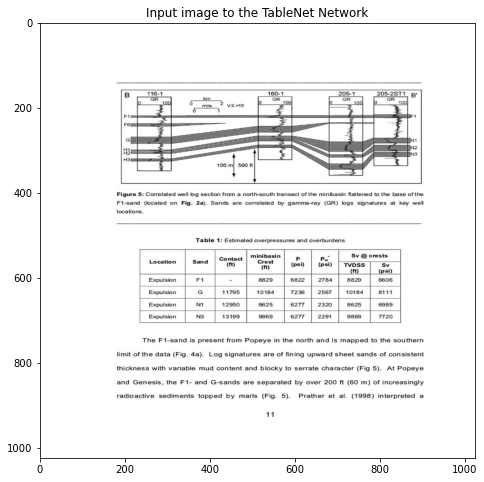

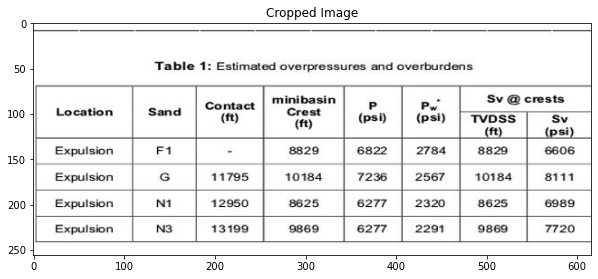

Table 1: Estimated overpressures and overburdens

minibasin - | sv@crosts
Contact ep | pe

tecation | Sand |") crest | (sn | (psi) [TwDss | Sv

(ft) (psi)
Expulsion | FA : 3520 | 6822 | 2784 | 8520 | e506
Expuision | G | 11705 | 10184 | 7236 | 2567 | 10184 | 8111
Expulsion | ni | 12050 | 8625 | 6277 | 2320 | 2625 | cose
Expuision | Ns | 13109 | 9869 | 6277 | 2201 | e869 | 7720




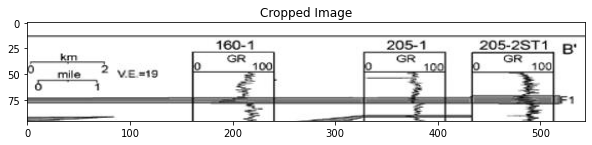

  160-1 205-4 205-2871 By
0                      GR
1                     10d


In [63]:
test_14 = r'C:\Users\ADMIN\Documents\Case study 2\marmot_preprocessed\image\10.1.1.193.1812_21.jpeg'
input_image, pred_table_mask, pred_column_mask = get_pred_masks(model_dense, test_14)
table_bound = fixMasks(pred_table_mask)
display(test_14)
Extraction(input_image, table_bound)

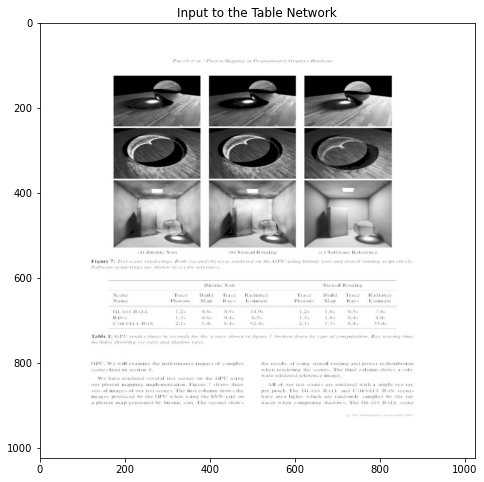

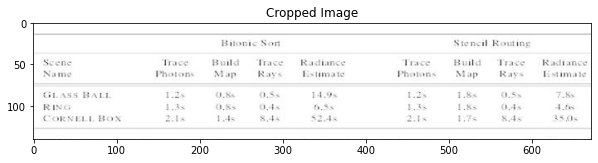

                         Hitonte Son Stencil Routing
0  Trace Build ‘Trace Radiance Trace Build ‘Trace...
1            Photons Map Rays Estimate Rays Estimate
2                                   er ar ars ass 78
3                              Has OS Os fase OAs Kt
4                                         Subs Beats
5                                   Qos Es Babs S2ds


In [66]:
test_15 = r'C:\Users\ADMIN\Documents\Case study 2\marmot_preprocessed\image\10.1.1.1.2075_6.jpeg'
input_image, pred_table_mask, pred_column_mask = get_pred_masks(model_dense, test_15)
table_bound = fixMasks(pred_table_mask)
display(test_15)
Extraction(input_image, table_bound)

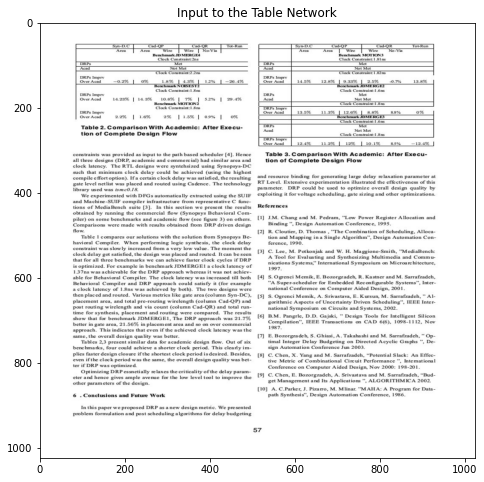

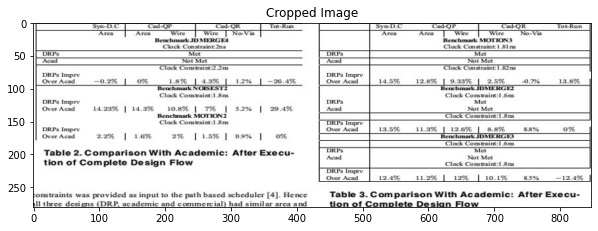

ba a. love Bede a estan
DRPs Impre z RP lmgey
QreAGe” 02% | o% 18% | asm | 12% | 20.4% Geracd | 145% 128% | oss% | 25% 07m 13.696
KaximmcNORESTT tein a
QvevAcad 14.23% | 14.8% 10.8% | 7% | 52% | 20.4% ‘Acad Not Met
‘Giok Conon Soe DR TT —
DP impev Ore Amd 11.3% | 120% | sos as 0%
QeAcd 22% | 16% 2% [15% | 09% | Om eae IOMERCET
Table 2. Comparison With Academic: After Execu- ad ee
tion of Complete Design Flow clock Comenint toe
Ra
Gerad | 124% 112% | 19% | wos as — 12.49% |

nstraints was provided as input to the path based scheduler [4]. Hence

ERT Gg A REAP TIEN CIELO ABILENE ATS

Table 3. Comparison With Academic: After Execu-

‘thick dat whine neeh a Widnes weil



In [67]:
test_16 = r'C:\Users\ADMIN\Documents\Case study 2\marmot_preprocessed\image\10.1.1.1.2103_4.jpeg'
input_image, pred_table_mask, pred_column_mask = get_pred_masks(model_dense, test_16)
table_bound = fixMasks(pred_table_mask)
display(test_16)
Extraction(input_image, table_bound)

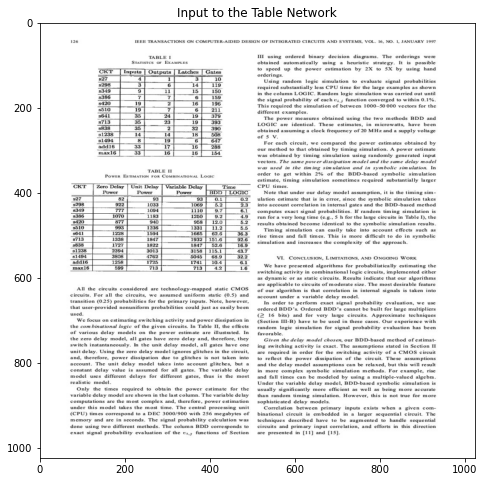

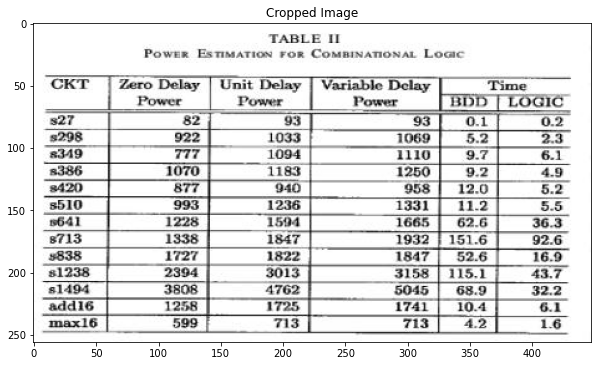

TABLE 1

Powe Exmuarion rox Commnanionat Loctc

GRE | aro Daley | Unit Delay | Variable Delay
Power * [np tae

wT ‘ae - 02

3298 22 | 7033 7085} 32 23

3319 77 a0 | 9.7

5386. 1070, 1250 |_9.2

3420 ‘Sr ~ 958 [12.0

3510 Ed Tsai | 11.2

641 228 1665 | 62.6 |

e713 1838 3932 J 151.6

838 crud isa7 | 52.6

1238 2304 | “3158 | 115.1

31494 ‘3808 ‘3045 | 68.9

addi 1258 i741 | 10.4

maxi6_ 399, 7a | 42




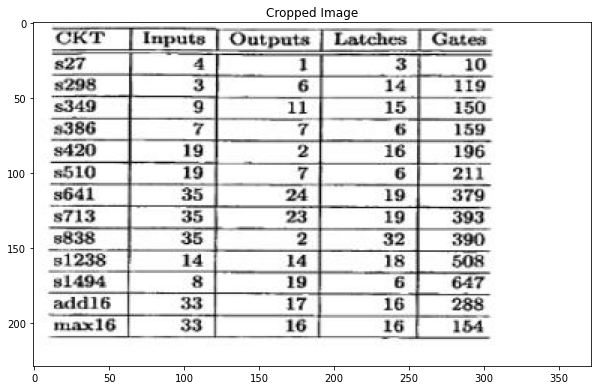

rere] Onipats | Torche [Gate

sy 30

Sa8 3 . ite
Bas +|——a1 | 15180
386—| —+ 7 me
S20 is [a6 | 198
aio 73 7 e[oat
35. 24 | 19 379

3s 35] is | 308

3 2} ——a3 | — 380

ia 1a [18 | “308

? is ef} cet

aa 17] 6 | 388

35 16 16 [isa




In [68]:
test_17 = r'C:\Users\ADMIN\Documents\Case study 2\marmot_preprocessed\image\10.1.1.1.2129_6.jpeg'
input_image, pred_table_mask, pred_column_mask = get_pred_masks(model_dense, test_17)
table_bound = fixMasks(pred_table_mask)
display(test_17)
Extraction(input_image, table_bound)

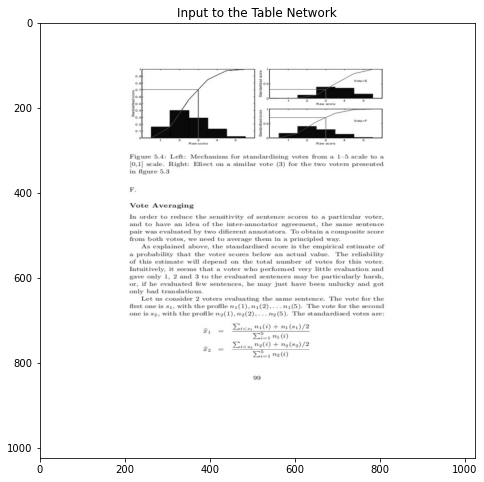

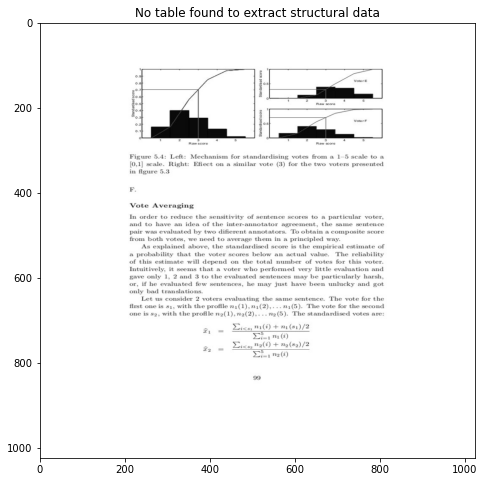

In [69]:
test_18 = r'C:\Users\ADMIN\Documents\Case study 2\marmot_preprocessed\image\10.1.1.1.2139_100.jpeg'
input_image, pred_table_mask, pred_column_mask = get_pred_masks(model_dense, test_18)
table_bound = fixMasks(pred_table_mask)
display(test_18)
Extraction(input_image, table_bound)

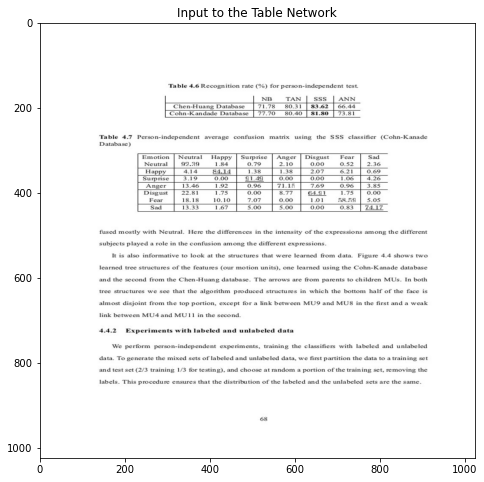

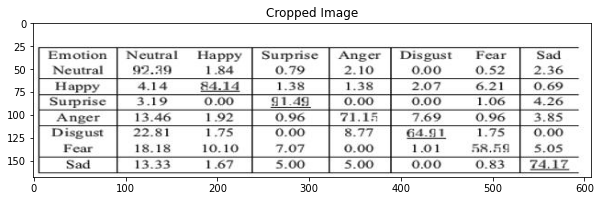

    Emotion     Surprise     |    Anger   |.1 Disgust  Fear     ]   Sad
0   Neutral         0.79  2.10     0.00  0.52       |  2.36  None   NaN
1     Happy         1.38  1.38  2076.21     |    0.69  None  None   NaN
2  Surprise  g14g_|_0.00  0.00     1.06     |    4.26  None  None   NaN
3     Anger         0.96     |     7115     |     769  0.96     |  3.85
4   Disgust         0.00  8.77        |   G41    1.75     |  0.00   NaN
5      Fear         7.07  0.00     1.01  5.05    None  None  None   NaN
6       Sad         5.00  5.00     0.00  0.83       |  7417  None   NaN


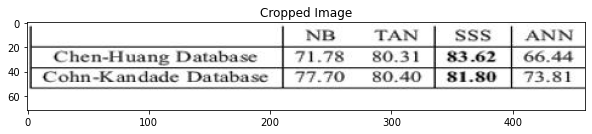

NB__TAN | SSS_| ANN
‘Chen-Huang Database_[ 71.78 80.31 | 83.62 | 66.44
CGohn-Kandade Database | 77.70 80.40 | 81.80 | 73.81




In [70]:
test_19 = r'C:\Users\ADMIN\Documents\Case study 2\marmot_preprocessed\image\10.1.1.6.2215_78.jpeg'
input_image, pred_table_mask, pred_column_mask = get_pred_masks(model_dense, test_19)
table_bound = fixMasks(pred_table_mask)
display(test_19)
Extraction(input_image, table_bound)

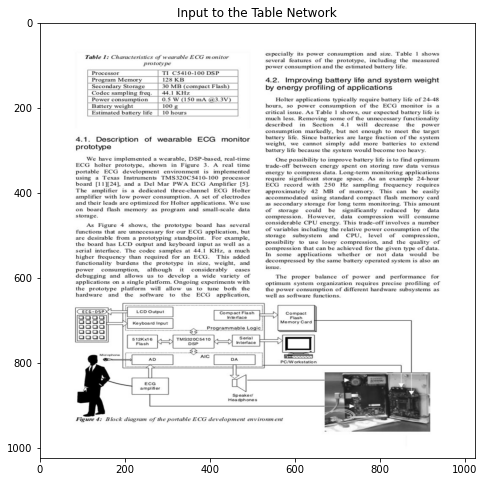

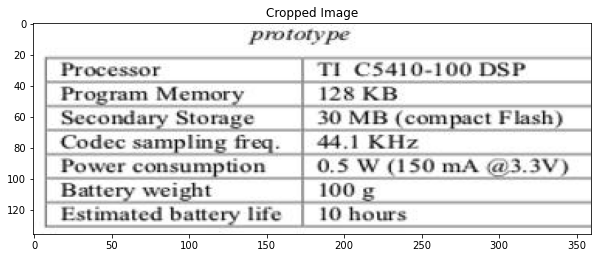

Prototype

Processor ‘TI _C3410-100 DSP
Program Memory 128 KB
‘Secondary Storage 30 MB (compact Flash)

‘Codec sampling freq. | 44.1 KHz

Power consumption __| 0.5 W (150 mA @3.3V)

Battery weight 100g

Estimated battery life_| 10 hours




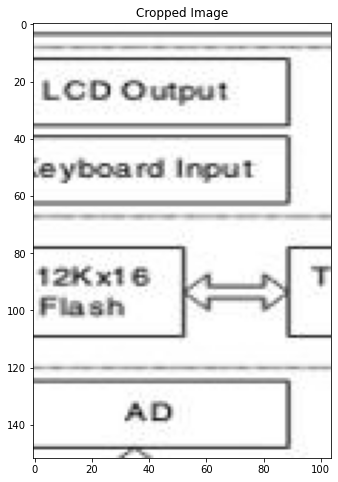

No data is identified by tesseract OCR


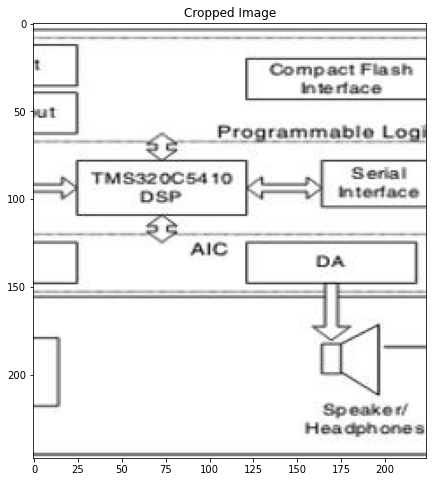

  TMSa2005410
0         ose
1         AiG


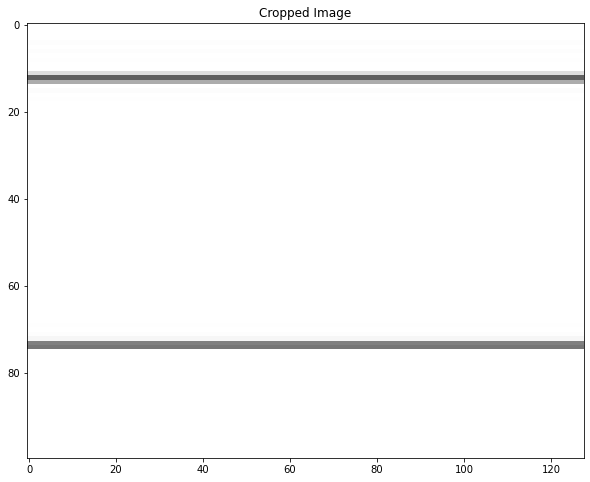

No data is identified by tesseract OCR


In [71]:
test_20 = r'C:\Users\ADMIN\Documents\Case study 2\marmot_preprocessed\image\10.1.1.33.5766_4.jpeg'
input_image, pred_table_mask, pred_column_mask = get_pred_masks(model_dense, test_20)
table_bound = fixMasks(pred_table_mask)
display(test_20)
Extraction(input_image, table_bound)

Steps followed for OCR extraction:

1. The line alignement i.e. the words are extracted by tesseract-ocr horizantal line wise. 
2. Words which lay on the same horizontal line are extracted one after another.
3. This behaviour would not help us to extract data row wise when the table has multiple lines.
4. Using python's StringIO created a stream of text which is used to create a pandas DataFrame to write over .csv files
5. For streams which can't be read by pandas DataFrame due to its limitations we have write it over general .text files

# Observations on Model predictions:

1. The Model tends to identify pixels containing bold letters as false positives @test_4 example
2. It also fails to distinguish between flow chart, circuits and table edges. @test_14, test_20 examples
3. It could distinguish between pictures and tables. @test_15, test_20 examples
4. For some documents the appropriated table boundaries tends to be cutoff outer columns. It effects generalization. @test_5 example
5. The approximation also causes merging of two very close tables. @test_16 example
6. It also fails to recognize the table without any partitions. @test_11 example